## Neural Translation Model

This notebook project will create a neural network that translates from English to German. It will utilize concepts such as building flexible model architectures, freezing layers, data processing pipelines, and sequence modeling.

First, run some imports and load the dataset:

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

import numpy as np
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive
from IPython.display import Image


from tensorflow.keras.layers import Input, LSTM, Masking, Embedding, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

A language dataset from http://www.manythings.org/anki/ will be used for this project to build a neural translation model. This dataset comprises over 200,000 pairs of sentences in English and German. To expedite training, the dataset will be restricted to 20,000 pairs. This restriction can be altered as desired; the dataset size used is not considered in the grading rubric.

The objective is to develop a neural translation model from English to German, utilizing a pre-trained English word embedding module.

#### Import the Data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

The unzipped folder should be stored in Drive for use in this Colab notebook.

In [2]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/My Drive/path/to/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [4]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)

    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence.strip()

#### The Custom Translation Model
The following is a schematic of the custom translation model architecture that will be developed in this project.

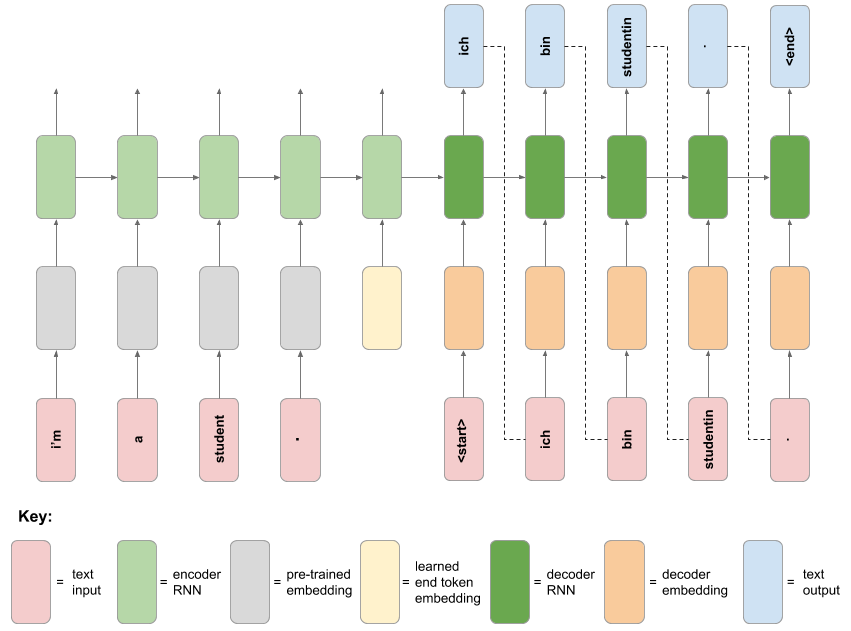

In [5]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text Preprocessing
In the code below:
* Separate lists of English and German sentences are created, and they are preprocessed using the `preprocess_sentence` function provided.
* A special `<start>` and `<end>` token is added to the beginning and end of every German sentence.
* The Tokenizer class from the `tf.keras.preprocessing.text` module is used to tokenize the German sentences, ensuring that no character filters are applied.
* At least 5 randomly chosen examples of (preprocessed) English and German sentence pairs are printed out. For each German sentence, both the text (with start and end tokens) and the tokenized sequence are printed.
* The tokenized German sequences are padded at the end with zeros, and the complete set of sequences is batched into one numpy array.

In [6]:


# Create separate lists of English and German sentences and preprocess them:

english_sentences = []
german_sentences = []

for line in data_examples:
    en, de, _ = line.strip().split('\t')
    english_sentences.append(preprocess_sentence(en))
    german_sentences.append(preprocess_sentence(de))

print(f"Number of sentence pairs: {len(english_sentences)}")


Number of sentence pairs: 20000


In [7]:


# Add special tokens to German sentences:

german_sentences = ['<start> ' + sentence + ' <end>' for sentence in german_sentences]


In [8]:


# Tokenize German sentences:

tokenizer = Tokenizer(filters='')
tokenizer.fit_on_texts(german_sentences)
german_sequences = tokenizer.texts_to_sequences(german_sentences)

print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")

Vocabulary size: 5744


In [9]:


# Print random examples:

def print_random_examples(num_examples=5):
    for _ in range(num_examples):
        idx = random.randint(0, len(english_sentences) - 1)
        print("English:", english_sentences[idx])
        print("German (text):", german_sentences[idx])
        print("German (tokenized):", german_sequences[idx])
        print()

print_random_examples()

English: i'm in the lobby .
German (text): <start> ich bin im foyer . <end>
German (tokenized): [1, 4, 15, 104, 4941, 3, 2]

English: get into the car .
German (text): <start> steig ins auto . <end>
German (tokenized): [1, 2025, 341, 82, 3, 2]

English: tom does his job .
German (text): <start> tom tut seine arbeit . <end>
German (tokenized): [1, 5, 150, 371, 163, 3, 2]

English: tom is deceitful .
German (text): <start> tom ist hinterlistig . <end>
German (tokenized): [1, 5, 6, 2331, 3, 2]

English: it's no secret .
German (text): <start> es ist kein geheimnis . <end>
German (tokenized): [1, 10, 6, 71, 955, 3, 2]



In [10]:


# Pad sequences and create numpy array:

max_sequence_length = max(len(seq) for seq in german_sequences)
german_padded = pad_sequences(german_sequences, maxlen=max_sequence_length, padding='post')

print(f"Shape of padded German sequences: {german_padded.shape}")


Shape of padded German sequences: (20000, 14)


## 2. Prepare the Data

#### Load the Embedding Layer
In the code below:
* A pre-trained English word embedding module from TensorFlow Hub is used as part of the dataset preprocessing for this project. The module is located at https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

* This embedding module takes a batch of text tokens in a 1-D tensor of strings as input and embeds each token into a 128-dimensional space.

* This model can also function as a sentence embedding module. It processes each token by removing punctuation and splitting on spaces, then averages the word embeddings over a sentence to produce a single embedding vector. However, for our purpose, it will be used strictly as a word embedding module, with each word in the input sentence passed as a separate token.

In [11]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1",
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [12]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

In the code below:

* A random training and validation set split of the data is created, with 20% of the data reserved for validation. Each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens.
* The training and validation sets are loaded into `tf.data.Dataset` objects, with tuples of English and German data provided for both sets.
* Functions are created to map over the datasets: 
  * One function splits each English sentence at spaces.
  * Another function embeds each sequence of English words using the loaded embedding layer/model.
  * A function filters out dataset examples where the English sentence is greater than or equal to 13 (embedded) tokens in length.
  * A function pads each English sequence of embeddings to a length of 13 using distinct padding values.
* These functions are applied to both Dataset objects using the map and filter methods as appropriate.
* Both the training and validation Datasets are batched with a batch size of 16.
* The `element_spec` property for the training and validation Datasets is printed.
* Using the Dataset `.take(1)` method:
  * The shape of the English data example from the training Dataset is printed.
  * The German data example Tensor from the validation Dataset is printed.

This approach ensures that the dataset preprocessing is conducted uniformly and efficiently across both training and validation sets, preparing the data for subsequent model training.

In [13]:


# Create random training and validation set split:

num_examples = len(english_sentences)
indices = np.arange(num_examples)
np.random.shuffle(indices)

split = int(0.8 * num_examples)
train_indices = indices[:split]
val_indices = indices[split:]

train_english = np.array(english_sentences)[train_indices]
train_german = german_padded[train_indices]
val_english = np.array(english_sentences)[val_indices]
val_german = german_padded[val_indices]

print(f"Training set size: {len(train_english)}")
print(f"Validation set size: {len(val_english)}")

Training set size: 16000
Validation set size: 4000


In [14]:


# Load data into tf.data.Dataset objects:

train_dataset = tf.data.Dataset.from_tensor_slices((train_english, train_german))
val_dataset = tf.data.Dataset.from_tensor_slices((val_english, val_german))

In [15]:


# Create and apply function to split English sentences:

def split_english(en, de):
    return tf.strings.split(en), de

train_dataset = train_dataset.map(split_english)
val_dataset = val_dataset.map(split_english)

In [16]:


# Create and apply function to embed English words:

def embed_english(en, de):
    return embedding_layer(en), de

train_dataset = train_dataset.map(embed_english)
val_dataset = val_dataset.map(embed_english)

In [17]:


# Create and apply filter function:

def filter_by_length(en, de):
    return tf.shape(en)[0] < 13

train_dataset = train_dataset.filter(filter_by_length)
val_dataset = val_dataset.filter(filter_by_length)

In [18]:


# Create and apply padding function:

def pad_to_13(en, de):
    padding = [[13 - tf.shape(en)[0], 0], [0, 0]]
    en_padded = tf.pad(en, padding, constant_values=-1)  # Use -1 as padding value
    return en_padded, de

train_dataset = train_dataset.map(pad_to_13)
val_dataset = val_dataset.map(pad_to_13)

In [19]:


# Batch the datasets:

BATCH_SIZE = 16
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

In [20]:


# Print element_spec for both datasets:

print("Training dataset element_spec:")
print(train_dataset.element_spec)
print("\nValidation dataset element_spec:")
print(val_dataset.element_spec)

Training dataset element_spec:
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))

Validation dataset element_spec:
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [21]:


# Print shape of English data example from training dataset:

for en, de in train_dataset.take(1):
    print("Shape of English data example from training dataset:", en.shape)

Shape of English data example from training dataset: (16, 13, 128)


In [22]:


# Print German data example from validation dataset:

for en, de in val_dataset.take(1):
    print("German data example from validation dataset:")
    print(de)

German data example from validation dataset:
tf.Tensor(
[[   1    4   51 3856    3    2    0    0    0    0    0    0    0    0]
 [   1   43   16 1807    7    2    0    0    0    0    0    0    0    0]
 [   1   45    8 1031    9    2    0    0    0    0    0    0    0    0]
 [   1   26   23   12   49    3    2    0    0    0    0    0    0    0]
 [   1    6   11  258    7    2    0    0    0    0    0    0    0    0]
 [   1   14  799    3    2    0    0    0    0    0    0    0    0    0]
 [   1   73   27 1062    7    2    0    0    0    0    0    0    0    0]
 [   1   32   13 1206    7    2    0    0    0    0    0    0    0    0]
 [   1 3139   22   12    9    2    0    0    0    0    0    0    0    0]
 [   1    5  296  171   20   54    3    2    0    0    0    0    0    0]
 [   1   26 2229    6  938    3    2    0    0    0    0    0    0    0]
 [   1    4   15   19 5711  193    3    2    0    0    0    0    0    0]
 [   1    8    6  322    3    2    0    0    0    0    0    0    0  

## 3. Create the Custom Layer
In the code below, a custom layer will be created to add the learned end token embedding to the encoder model:

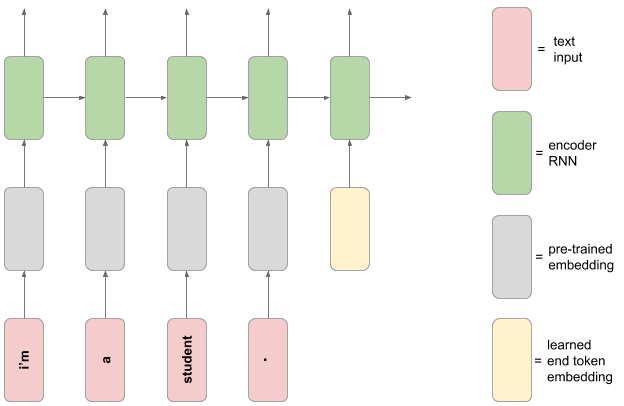

In [23]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

In the code below:

* A custom layer will be created using layer subclassing. This layer will take a batch of English data examples from one of the Datasets and add a learned embedded `‘end’` token to the end of each sequence.
* Within this layer, a TensorFlow Variable will be created, which is 128-dimensional (matching the size of the embedding space). To replicate the end token embedding across every element in the batch, the tf.tile function may be utilized effectively within the call method.
* Using the Dataset `.take(1)` method, a batch of English data examples will be extracted from the training Dataset, and the shape of this batch will be printed.
* The custom layer will be tested by calling it on the English data batch Tensor, and the resulting Tensor shape will be printed (expecting an increase in sequence length by one due to the added end token).

In [24]:


# Create a custom layer using layer subclassing:

class AddEndToken(tf.keras.layers.Layer):
    def __init__(self):
        super(AddEndToken, self).__init__()
        self.end_token = self.add_weight(
            name='end_token',
            shape=(128,),
            initializer='random_normal',
            trainable=True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        tiled_end_token = tf.tile(tf.expand_dims(self.end_token, 0), [batch_size, 1])
        tiled_end_token = tf.expand_dims(tiled_end_token, 1)
        return tf.concat([inputs, tiled_end_token], axis=1)

In [25]:


# Test the custom layer:

# Extract a batch of English data examples from the training Dataset
for en_batch, _ in train_dataset.take(1):
    print("Shape of English data batch:", en_batch.shape)

    # Create an instance of the custom layer
    add_end_token_layer = AddEndToken()

    # Apply the custom layer to the English data batch
    result = add_end_token_layer(en_batch)
    print("Shape after adding end token:", result.shape)

Shape of English data batch: (16, 13, 128)
Shape after adding end token: (16, 14, 128)


## 4. Build the Encoder Network
In the code below:

* The encoder network is constructed following the schematic diagram provided. The RNN encoder model will be built using the functional API.
* The model takes a batch of sequences of embedded English words as input, sourced from the Dataset objects.
* The custom layer created previously is incorporated next in the encoder to add a learned end token embedding to the end of each English sequence.
* A Masking layer follows, where the `mask_value` is set to the distinct padding value used during the Dataset preprocessing of English sequences.
* The final layer of the encoder is an LSTM layer with 512 units, configured to return both the hidden state and cell state outputs.
* The encoder model is designed as a multi-output model, producing two output Tensors: the hidden state and cell states from the LSTM layer (the LSTM layer output itself is unused).

* Using the Dataset `.take(1)` method, a batch of English data examples is extracted from the training Dataset. The encoder model is then tested by invoking it on the English data Tensor, and the shape of the resulting Tensor outputs is printed.
* Finally, the model summary for the encoder network is printed to provide an overview of its architecture and parameters.

In [26]:


# Build the encoder network using the functional API:

def build_encoder():
    # Input layer
    inputs = Input(shape=(13, 128))  # 13 is the padded sequence length, 128 is the embedding dim

    # Custom layer to add end token
    x = AddEndToken()(inputs)

    # Masking layer
    x = Masking(mask_value=-1)(x)  # -1 was used as the padding value

    # LSTM layer
    lstm_outputs, state_h, state_c = LSTM(512, return_state=True, return_sequences=True)(x)

    # Create the model
    encoder = Model(inputs=inputs, outputs=[state_h, state_c])

    return encoder

# Create the encoder model
encoder = build_encoder()

In [27]:


# Test the encoder model:

# Extract a batch of English data examples from the training Dataset
for en_batch, _ in train_dataset.take(1):
    # Call the encoder on the English data Tensor
    h_state, c_state = encoder(en_batch)

    print("Input shape:", en_batch.shape)
    print("Hidden state shape:", h_state.shape)
    print("Cell state shape:", c_state.shape)

Input shape: (16, 13, 128)
Hidden state shape: (16, 512)
Cell state shape: (16, 512)


In [28]:


# Print the model summary:

encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13, 128)]         0         
                                                                 
 add_end_token_1 (AddEndTok  (None, 14, 128)           128       
 en)                                                             
                                                                 
 masking (Masking)           (None, 14, 128)           0         
                                                                 
 lstm (LSTM)                 [(None, 14, 512),         1312768   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1312896 (5.01 MB)
Trainable params: 1312896 (5.01 MB)
Non-trainable params: 0 (0.00 Byte)
_______________________

## 5. Build the Decoder Network
The decoder network follows the schematic diagram below.

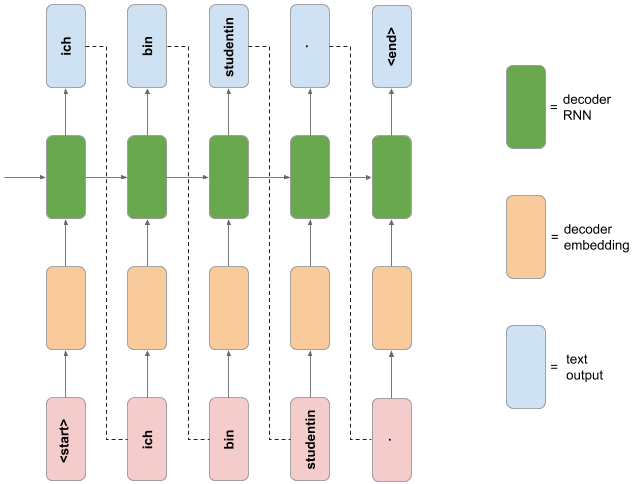

In [29]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

In the code below:

* The decoder network is constructed using Model subclassing, adhering to the specified specifications:
  * The initializer sets up the following layers:
    * An Embedding layer with a vocabulary size corresponding to the number of unique German tokens, embedding dimension of 128, and configured to mask zero values in the input.
    * An LSTM layer with 512 units that returns its hidden and cell states, and also returns sequences.
    * A Dense layer with units equal to the number of unique German tokens, without any activation function.
  * The call method includes the usual `inputs` argument along with additional keyword arguments `hidden_state` and `cell_state`, defaulted to `None`.
  * Within the call method, inputs are passed through the Embedding layer and subsequently through the LSTM layer. If provided, the `hidden_state` and `cell_state` arguments are utilized as the initial states using the `initial_state` keyword argument when invoking the LSTM layer.
  * The LSTM output sequence is processed through the Dense layer, and the resulting Tensor is returned along with the hidden and cell states of the LSTM layer.

* Using the Dataset `.take(1)` method, a batch of English and German data examples is extracted from the training Dataset. The decoder model is then tested by first calling the encoder model on the English data Tensor to obtain the hidden and cell states. Subsequently, the decoder model is called on the German data Tensor along with the retrieved hidden and cell states, and the shape of the resulting decoder Tensor outputs is printed.

* Finally, the model summary for the decoder network is printed to provide an overview of its architecture and parameters.

In [30]:


# Build the decoder network using Model subclassing:

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size):
        super(Decoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, 128, mask_zero=True)
        self.lstm = tf.keras.layers.LSTM(512, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, hidden_state=None, cell_state=None):
        x = self.embedding(inputs)

        if hidden_state is not None and cell_state is not None:
            lstm_output, state_h, state_c = self.lstm(x, initial_state=[hidden_state, cell_state])
        else:
            lstm_output, state_h, state_c = self.lstm(x)

        output = self.dense(lstm_output)

        return output, state_h, state_c

# Create the decoder model
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the padding token
decoder = Decoder(vocab_size)

In [31]:


# Test the decoder model:

# Extract a batch of English and German data examples from the training Dataset
for en_batch, de_batch in train_dataset.take(1):
    # Call the encoder on the English data Tensor
    h_state, c_state = encoder(en_batch)

    # Call the decoder on the German data Tensor and encoder states
    decoder_output, _, _ = decoder(de_batch, hidden_state=h_state, cell_state=c_state)

    print("Input shape:", de_batch.shape)
    print("Decoder output shape:", decoder_output.shape)

Input shape: (16, 14)
Decoder output shape: (16, 14, 5744)


In [32]:


# Print the model summary:

# Create a sample input to build the model
sample_input = tf.zeros((1, max_sequence_length))  # Use the max_sequence_length from earlier

# Call the model to build it
decoder(sample_input)

# Print the model summary
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  735232    
                                                                 
 lstm_1 (LSTM)               multiple                  1312768   
                                                                 
 dense (Dense)               multiple                  2946672   
                                                                 
Total params: 4994672 (19.05 MB)
Trainable params: 4994672 (19.05 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## 6. Make a Custom Training Loop
In the code below:

* A function will be defined to extract German inputs and outputs for the decoder model from a Tensor batch of German data, as extracted from the training Dataset.
* A function will be defined with the `@tf.function` decorator that computes the forward and backward pass for the translation model. This function will take an English input, German input, and German output as arguments, and perform the following steps:
  * Pass the English input into the encoder to obtain the hidden and cell states of the encoder LSTM.
  * Use these hidden and cell states as well as the German inputs to feed into the decoder, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are not used in this function).
  * Compute the loss between the decoder outputs and the German output provided as a function argument.
  * Return the computed loss and gradients with respect to the encoder's and decoder's trainable variables.
* Define and execute a custom training loop over a specified number of epochs:
  * Iterate through the training dataset, generating decoder inputs and outputs from the German sequences.
  * Update the parameters of the translation model using the gradients obtained from the function above and an optimizer object.
  * Calculate the validation loss every epoch on a number of batches from the validation dataset, and store both the epoch training and validation losses.
* Finally, plot the learning curves showing loss versus epoch for both the training and validation sets, providing insights into the model's training progress.

This approach ensures the development of a custom neural translation model with a robust training loop, capable of optimizing parameters and monitoring performance through comprehensive learning curves.

In [33]:


# Define a function to prepare decoder inputs and outputs:

def prepare_decoder_input_output(german_batch):
    decoder_input = german_batch[:, :-1]  # All but the last token
    decoder_output = german_batch[:, 1:]  # All but the first token
    return decoder_input, decoder_output

In [34]:


# Define the forward and backward pass function:

@tf.function
def train_step(encoder, decoder, optimizer, english_input, german_input, german_output):
    with tf.GradientTape() as tape:
        # Encoder forward pass
        enc_hidden, enc_cell = encoder(english_input)

        # Decoder forward pass
        decoder_output, _, _ = decoder(german_input, hidden_state=enc_hidden, cell_state=enc_cell)

        # Compute loss
        loss = tf.keras.losses.sparse_categorical_crossentropy(german_output, decoder_output, from_logits=True)
        loss = tf.reduce_mean(loss)

    # Compute gradients
    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, variables))

    return loss

In [35]:


# Define and run the custom training loop:

def train_model(encoder, decoder, train_dataset, val_dataset, epochs=10):
    optimizer = tf.keras.optimizers.Adam()
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0
        train_steps = 0
        val_steps = 0

        # Training loop
        for english_batch, german_batch in train_dataset:
            german_input, german_output = prepare_decoder_input_output(german_batch)
            loss = train_step(encoder, decoder, optimizer, english_batch, german_input, german_output)
            total_train_loss += loss
            train_steps += 1

        # Validation loop
        for english_batch, german_batch in val_dataset.take(100):  # Limit validation to 100 batches
            german_input, german_output = prepare_decoder_input_output(german_batch)
            enc_hidden, enc_cell = encoder(english_batch)
            decoder_output, _, _ = decoder(german_input, hidden_state=enc_hidden, cell_state=enc_cell)
            val_loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(german_output, decoder_output, from_logits=True))
            total_val_loss += val_loss
            val_steps += 1

        # Compute average losses
        avg_train_loss = total_train_loss / train_steps
        avg_val_loss = total_val_loss / val_steps

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    return train_losses, val_losses

# Run the training
train_losses, val_losses = train_model(encoder, decoder, train_dataset, val_dataset, epochs=10)

Epoch 1, Train Loss: 5.4777, Val Loss: 4.8362
Epoch 2, Train Loss: 4.3236, Val Loss: 3.9839
Epoch 3, Train Loss: 3.4366, Val Loss: 3.2542
Epoch 4, Train Loss: 2.6244, Val Loss: 2.5883
Epoch 5, Train Loss: 1.8854, Val Loss: 2.0101
Epoch 6, Train Loss: 1.2643, Val Loss: 1.5721
Epoch 7, Train Loss: 0.8233, Val Loss: 1.3106
Epoch 8, Train Loss: 0.5574, Val Loss: 1.1792
Epoch 9, Train Loss: 0.4016, Val Loss: 1.1251
Epoch 10, Train Loss: 0.3035, Val Loss: 1.0918


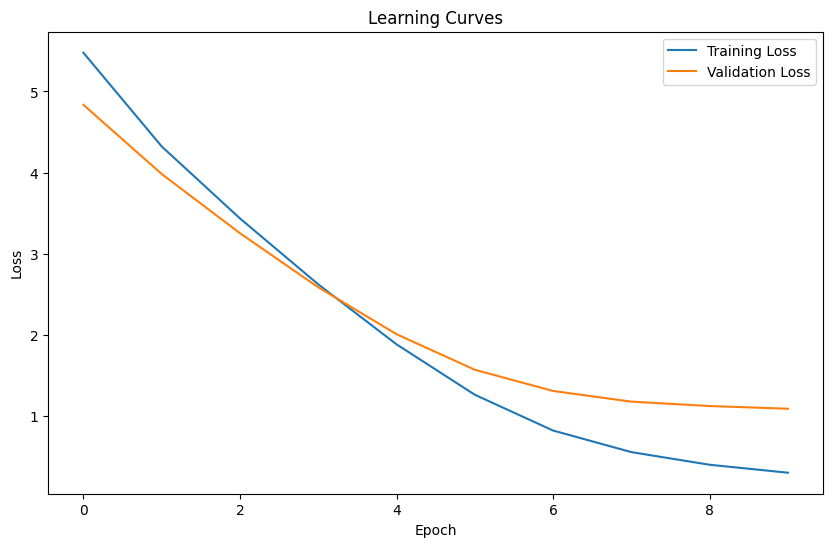

In [36]:


# Plot the learning curves:

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 7. Use the Model to Translate
In the code below:

* The model is put into practice by running translations for five randomly sampled English sentences from the dataset. For each sentence, the following steps are performed:
  * The English sentence is preprocessed and embedded according to the model requirements.
  * The embedded sentence is passed through the encoder to obtain the encoder hidden and cell states.
  * Starting with the special `"<start>"` token, this token and the final encoder hidden and cell states are used to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
  * A loop is created to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. The loop terminates when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
  * The output token sequence is decoded into German text, and both the English text and the model's German translation are printed.

In [40]:


import random

def translate_sentence(sentence, encoder, decoder, max_length=20):
    # Preprocess the English sentence
    preprocessed_sentence = preprocess_sentence(sentence)

    # Tokenize and embed the English sentence
    tokens = tf.strings.split([preprocessed_sentence])[0]
    embedded_tokens = embedding_layer(tokens)
    embedded_tokens = tf.expand_dims(embedded_tokens, 0)  # Add batch dimension

    # Pad the embedded tokens to length 13
    padded_tokens = tf.pad(embedded_tokens, [[0, 0], [0, 13 - tf.shape(embedded_tokens)[1]], [0, 0]], constant_values=-1)

    # Pass through encoder
    enc_hidden, enc_cell = encoder(padded_tokens)

    # Prepare decoder input
    decoder_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)

    output_sentence = []

    for _ in range(max_length):
        # Get prediction and updated states from decoder
        predictions, dec_hidden, dec_cell = decoder(decoder_input, hidden_state=enc_hidden, cell_state=enc_cell)

        # Get the predicted token
        predicted_id = tf.argmax(predictions[0, 0]).numpy()

        # Convert the predicted token to a word
        predicted_word = tokenizer.index_word[predicted_id]

        # Add the predicted word to the output sentence
        output_sentence.append(predicted_word)

        # Check if we've generated the end token
        if predicted_word == '<end>':
            break

        # Update the decoder input for the next step
        decoder_input = tf.expand_dims([predicted_id], 0)
        enc_hidden, enc_cell = dec_hidden, dec_cell

    return ' '.join(output_sentence)

# Randomly sample 5 English sentences and translate them
for _ in range(5):
    index = random.randint(0, len(english_sentences) - 1)
    english_sentence = english_sentences[index]
    german_translation = translate_sentence(english_sentence, encoder, decoder)

    print("English:", english_sentence)
    print("Translated German:", german_translation)
    print("Actual German:", german_sentences[index])
    print()

English: be objective .
Translated German: seien sie gnadenlos ! <end>
Actual German: <start> seien sie objektiv . <end>

English: i brought flowers .
Translated German: ich habe wein . <end>
Actual German: <start> ich habe blumen mitgebracht . <end>

English: i was upset .
Translated German: ich war beeindruckt . <end>
Actual German: <start> ich war bestuerzt . <end>

English: tom nodded .
Translated German: tom hat gegessen . <end>
Actual German: <start> tom nickte . <end>

English: it's a fungus .
Translated German: er ist eine wucht ! <end>
Actual German: <start> es ist ein pilz . <end>

